In [100]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import scipy
import math
sys.path.append('/home/eduardo/PycharmProjects/treemap-analysis/code')

import Parser
import TemporalMetrics

In [101]:
def styleBoxplot(bp, ax, n_revisions):
    
    def get_ax_size(ax):
        bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
        width, height = bbox.width, bbox.height
        width *= fig.dpi
        height *= fig.dpi
        return width, height
    
    for box in bp['boxes']:
        # change outline color
        box.set(color='#1b9e77', linewidth=0)
        # change fill color
        box.set(facecolor='#1b9e77')
        box.set_zorder(10)
    for i, median in enumerate(bp['medians']):
        median.set(color='#1445FF', linewidth=2, ms=(get_ax_size(ax)[0])/(n_revisions))
        median.set_zorder(11)
        median.set_xdata([i + 1 - 0.3, i + 1 + 0.3])
    for whisker in bp['whiskers']:
        # Butt remove excess lenght of linewidth
        whisker.set(color='#CCCCCC', linestyle='-', solid_capstyle="butt", linewidth=(get_ax_size(ax)[0])/(n_revisions))
    for cap in bp['caps']:
        cap.set(color='#FFFFFF', linewidth=0)
        
    #print(plt.getp(bp['whiskers'][0]))
        
    # ax.set_ylim([0, 1])
    
    # Set only 3 ticks on x
    ax.set_xticks([1, n_revisions / 2, n_revisions], minor=False)
    ax.set_xticklabels([1, int(n_revisions / 2), n_revisions], fontdict=None, minor=False)
    
    # Remove extra spines and ticks
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_zorder(20)
    ax.spines['bottom'].set_zorder(20)
    ax.tick_params(axis='x', which='both', top='off', direction='out')
    ax.tick_params(axis='y', which='both', right='off', direction='out')

def cm2inch(value):
    return value/2.54

In [102]:
# def point_hyperbole_dist(x, w, h, a):
#     # Distance between a point (w,h) and a hyperbole y = a/4x where a is the area we are trying to reach
#     return math.sqrt((x - w/2)**2 + (a/(4*x) - h/2)**2)

In [103]:
# # minimize (x-w/2)**2 + (a/(4*x) - h/2)**2, 
w = 0.63122
h = 1.5842
a = w*h

result = scipy.optimize.minimize(point_hyperbole_dist, x0=w, args=(w,h,a))
result

      fun: 2.012871950321718e-08
 hess_inv: array([[ 0.20196027]])
      jac: array([  8.27342506e-09])
  message: 'Optimization terminated successfully.'
     nfev: 102
      nit: 2
     njev: 34
   status: 0
  success: True
        x: array([ 0.31560999])

In [104]:
optimum_x = result.x[0]
# Minimum corner travel is 4 times the minimum point-hyperbole distance
min_dist = point_hyperbole_dist(optimum_x, w, h, a) * 4
min_dist

8.051487801286872e-08

In [105]:
def point_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

def corner_travel(*args):
    x1, y1, w1, h1, x2, y2, w2, h2 = args
    if math.isnan(w1):
        # 2 times the hypotenuse -- growth from center
        return 2 * math.sqrt(w2 ** 2 + h2 ** 2)
    elif math.isnan(w2):
        return 2 * math.sqrt(w1 ** 2 + h1 ** 2)
    else:
        return point_distance(x1, y1, x2, y2)   \
            + point_distance(x1 + w1, y1, x2 + w2, y2)   \
            + point_distance(x1, y1 + h1, x2, y2 + h2)   \
            + point_distance(x1 + w1, y1 + h1, x2 + w2, y2 + h2)

def delta_vis(df1, df2):
    base_width = (df1['x'] + df1['w']).max()
    base_height = (df1['y'] + df1['h']).max()
    # Normalize by 4 * hypotenuse
    #norm = 4 * math.sqrt(base_width ** 2 + base_height ** 2)

    df = pd.merge(df1, df2, how='inner', left_index=True, right_index=True)
    df.columns = ['x1', 'y1', 'w1', 'h1', 'x2', 'y2', 'w2', 'h2']
    df['delta_vis'] = df.apply(lambda r: corner_travel(*list(r)), axis=1)
    return df[['delta_vis']]

In [106]:
def point_hyperbole_dist(x, w, h, a):
    # Distance between a point (w,h) and a hyperbole y = a/4x where a is the area we are trying to reach
    return math.sqrt((x - w/2)**2 + (a/(4*x) - h/2)**2)

def unavoidable_travel(*args):
    x1, y1, w1, h1, x2, y2, w2, h2 = args
    if h1*w1 - w2*h2 < 0.00001:
        return 0
    else:
        result = scipy.optimize.minimize(point_hyperbole_dist, x0=w1, args=(w1,h1,w2*h2))
        optimum_x = result.x[0]
        # Minimum corner travel is 4 times the minimum point-hyperbole distance
        return point_hyperbole_dist(optimum_x, w1, h1, w2*h2) * 4
    

def unavoidable_movement(df1, df2):
    base_width = (df1['x'] + df1['w']).max()
    base_height = (df1['y'] + df1['h']).max()
    # Normalize by 4 * hypotenuse
    norm = 4 * math.sqrt(base_width ** 2 + base_height ** 2)

    df = pd.merge(df1, df2, how='inner', left_index=True, right_index=True)
    df.columns = ['x1', 'y1', 'w1', 'h1', 'x2', 'y2', 'w2', 'h2']
    df['unavoidable'] = df.apply(lambda r: unavoidable_travel(*list(r)), axis=1)
    return df[['unavoidable']]

In [107]:
history = Parser.parse_rectangles('sqr', 'calcuta')
#for i in range(1, len(history)):
i = 10
df = delta_vis(history[i - 1], history[i])
df = pd.merge(df, TemporalMetrics.delta_data_by_area(history[i - 1], history[i]), left_index=True, right_index=True)

df = pd.merge(df, unavoidable_movement(history[i - 1], history[i]), left_index=True, right_index=True)
df['diff'] = df['delta_vis'] - df['unavoidable'] 

base_width = (history[i - 1]['x'] + history[i - 1]['w']).max()
base_height = (history[i - 1]['y'] + history[i - 1]['h']).max()
# Normalize by 4 * hypotenuse
norm = 4 * math.sqrt(base_width ** 2 + base_height ** 2)
df['diff'] = df['diff'] / norm
df

,delta_vis,delta_data,unavoidable,diff
id,,,,
p/src/androidTest/java/com/iwsbrazil/calcuta/ExampleInstrumentedTest.java,9.338872,0.002823,9.332881,0.000001
p/src/main/AndroidManifest.xml,145.373188,0.003080,10.540099,0.023835
p/src/main/java/com/iwsbrazil/calcuta/CalcutaApplication.java,564.116562,0.004552,34.126506,0.093690
p/src/main/java/com/iwsbrazil/calcuta/model/social/FacebookManager.java,625.261253,0.016150,74.202837,0.097414
p/src/main/java/com/iwsbrazil/calcuta/util/Status.java,1549.134371,0.000869,3.304982,0.273267
p/src/main/java/com/iwsbrazil/calcuta/view/fragment/MyEventsFragment.java,767.196632,0.001741,0.000000,0.135622
p/src/main/java/com/iwsbrazil/calcuta/view/login/LoginActivity.java,758.535082,0.009843,63.788081,0.122815
p/src/main/java/com/iwsbrazil/calcuta/view/MainActivity.java,772.220769,0.008865,60.466749,0.125822
p/src/main/java/com/iwsbrazil/calcuta/view/myevents/adapter/EventsAdapter.java,872.147226,0.006081,34.399130,0.148094


IndexError: list index out of range

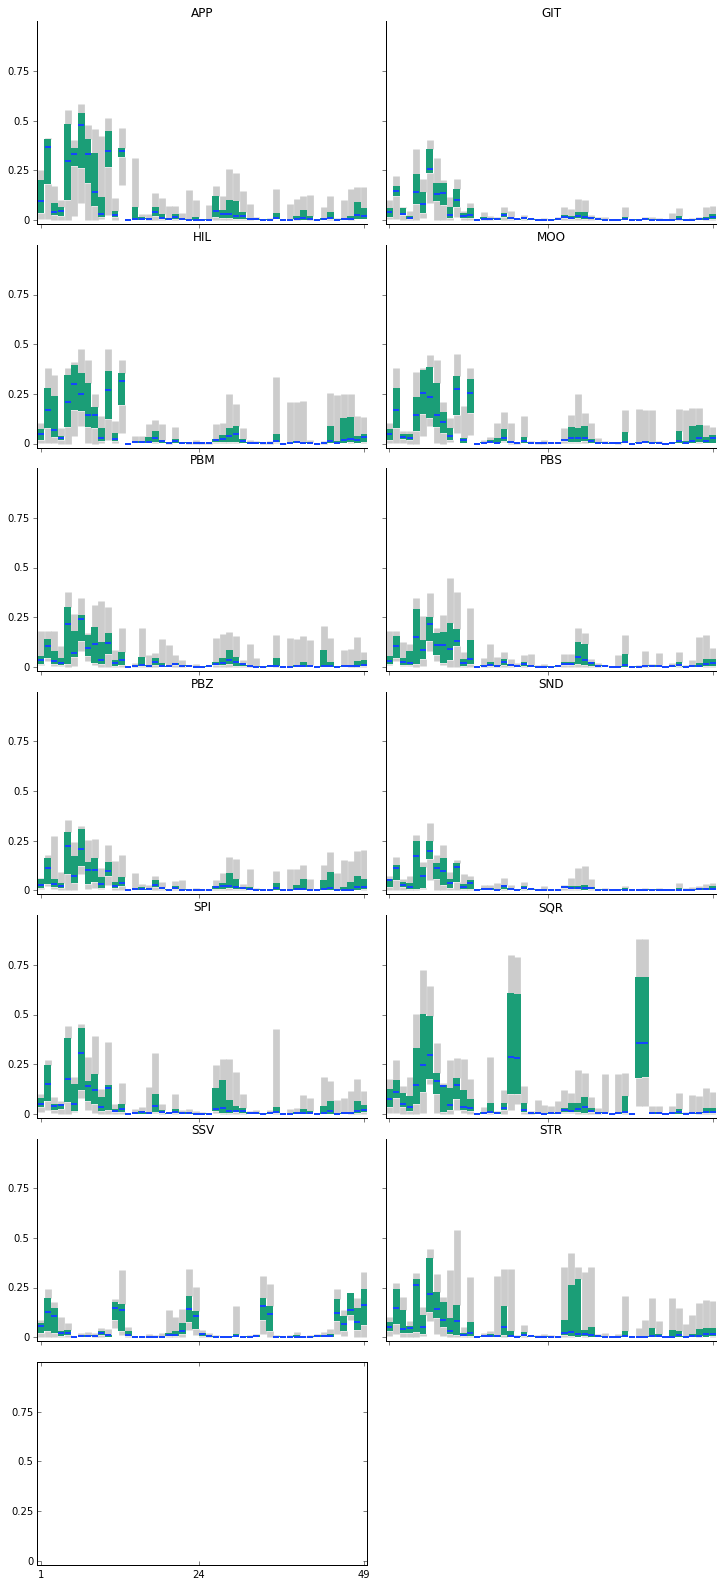

In [110]:
dataset_id = 'calcuta'
technique_list = Parser.list_techniques()
nrow = 7
ncol = 2
fig, axs = plt.subplots(nrow, ncol, sharex=True, sharey=True, figsize=(10, 22))
fig.delaxes(axs[6, 1])
fig.tight_layout()
for i, ax in enumerate(fig.axes):
    ax.set_title(technique_list[i].upper())

    data = []
    history = Parser.parse_rectangles(technique_list[i], dataset_id)
    for i in range(1, len(history)):
        df = delta_vis(history[i - 1], history[i])
        df = pd.merge(df, unavoidable_movement(history[i - 1], history[i]), left_index=True, right_index=True)
        df['diff'] = df['delta_vis'] - df['unavoidable'] 
        
        base_width = (history[i - 1]['x'] + history[i - 1]['w']).max()
        base_height = (history[i - 1]['y'] + history[i - 1]['h']).max()
        # Normalize by 4 * hypotenuse
        norm = 4 * math.sqrt(base_width ** 2 + base_height ** 2)
        df['diff'] = df['diff'] / norm
        
        column = 't' + str(i)
        data.append(df['diff'])

    bp = ax.boxplot(data, whis=[5, 95], showfliers=False, patch_artist=True, widths=1);
    
    ax.set_ylim(ymin=-0.02, ymax=1)
    ax.set_yticks([0, .25, .5, .75], minor=False)
    ax.set_yticklabels([0, .25, .5, .75], fontdict=None, minor=False)
    styleBoxplot(bp, ax, len(data))
    


#fig.savefig('time/svg/' + dataset_id + '_stab.svg', format='svg', dpi=1200)